## FEATURES

* dataset mas grande (2000 datos)
* Mas variables (piscina, parrillero, año de construcción, etc.)

In [1]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder = '/content/drive/MyDrive/MaestriaDataScience/Tesis/final_dataset_2025-09-08.xlsx'

In [4]:

import pandas as pd

data = pd.read_excel(folder)

In [5]:
data.head()

,url,precio,Baños,Superficie,Superficie Construida,Superficie Terreno,Garage,Dormitorio,barrio,municipio,precio_por_m2_construido,precio_por_m2_terreno,precio_por_m2
0,https://www.casasymas.com.uy/propiedad/183266-...,850000,3,429.0,256.0,429.0,4,4,carrasco,E,3320.312500,1981.351981,1981.351981
1,https://www.casasymas.com.uy/propiedad/940-cas...,380000,3,130.0,130.0,150.0,1,3,carrasco,E,2923.076923,2533.333333,2923.076923
2,https://www.casasymas.com.uy/propiedad/159162-...,119000,1,380.0,62.0,380.0,0,2,tres-cruces,B,1919.354839,313.157895,313.157895
3,https://www.casasymas.com.uy/propiedad/133140-...,1780000,4,263.0,263.0,1316.0,3,3,san-nicolas,E,6768.060837,1352.583587,6768.060837
4,https://www.casasymas.com.uy/propiedad/205399-...,370000,3,497.0,195.0,497.0,1,3,buceo,CH,1897.435897,744.466801,744.466801


## Funciones Auxiliares

Para automatizar entrenamiento de modelos y ahorrar tiempo. Luego invocaremos las funciones para entrenar.

In [6]:
def split_data_log(df, features: list, target: list):
  X = features
  y = np.log(target)
  X = X.fillna(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def split_data_with_preprocessing(
    df,
    target: str,
    num_cols: list,
    cat_cols: list,
    test_size: float = 0.20,
    random_state: int = 42
):
    # Transformación logarítmica del target
    y = np.log(df[target])

    # Features sin target
    X = df[num_cols + cat_cols]

    # División simple: train vs test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Preprocesador combinado
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    # Ajustar preprocess SOLO en training
    preprocess.fit(X_train)

    # Transformar datos
    X_train_prep = preprocess.transform(X_train)
    X_test_prep = preprocess.transform(X_test)

    return (
        X_train_prep, X_test_prep,
        y_train, y_test,
        preprocess,
        X_test.index
    )


In [8]:
def linear_regression_model(X_train, y_train):
  model_lr = LinearRegression()
  model_lr.fit(X_train, y_train)
  return model_lr

In [9]:
import lightgbm as lgb

def lightgbm_model(X_train, y_train, params=None):

    # Parámetros por defecto optimizados para MAE

    if params is None:
        params = {
            "objective": "l1",
            "metric": "mae",
            "learning_rate": 0.03,
            "num_leaves": 31,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5
        }

    train_data = lgb.Dataset(X_train, label=y_train)

    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=500
    )

    return model

In [10]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.01,
        objective="reg:absoluteerror",
        random_state=42,
        tree_method="hist"
    )

    model.fit(X_train, y_train)
    return model


In [11]:
from sklearn.model_selection import GridSearchCV

def train_xgboost_gridsearch(X_train, y_train, cv_folds=5, n_jobs=-1):

    param_grid = {
        "n_estimators": [600, 900, 1200],
        "learning_rate": [0.01, 0.03, 0.05],
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.7, 0.85, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [1.0, 2.0, 5.0],
        "reg_alpha": [0, 0.01, 0.1]
    }

    xgb = XGBRegressor(
        objective="reg:absoluteerror",
        tree_method="hist",
        random_state=42
    )

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",  # optimizar MAE
        cv=cv_folds,
        verbose=1,
        n_jobs=n_jobs
    )

    grid.fit(X_train, y_train)

    print("\n======== MEJORES PARÁMETROS XGBOOST ========")
    print(grid.best_params_)
    print("\nMejor MAE (en log-space):", -grid.best_score_)
    print("=============================================\n")

    # Modelo final con los mejores hiperparámetros
    best_model = grid.best_estimator_

    return best_model


In [12]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=600,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    return rf

In [13]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [14]:
def crear_tabla_resultados(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
    resultados = []

    for nombre, mse, r2, mae, medae, mape, mdape in zip(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
        resultados.append({
            "Modelo": nombre,
            "MAE": mae,
            "MEDAE": medae,
            "MSE": mse,
            "R2": r2,
            "MAPE": mape,
            "MDAPE": mdape
        })

    df_resultados = pd.DataFrame(resultados)
    pd.options.display.float_format = '{:,.2f}'.format
    return df_resultados


In [15]:
def evaluation_table(model, X_test_prep, y_test, df_original, extra_cols=None):

    # Predicción en log
    y_pred_log = model.predict(X_test_prep)

    # Convertir a precio real
    y_pred_real = np.exp(y_pred_log)
    y_test_real = np.exp(y_test)

    # Tabla base
    results = pd.DataFrame({
        "Precio Real": y_test_real,
        "Precio Predicho": y_pred_real,
    })

    results["Error Absoluto"] = np.abs(results["Precio Real"] - results["Precio Predicho"])
    results["Error %"] = 100 * results["Error Absoluto"] / results["Precio Real"]

    # Agregar columnas originales
    if extra_cols:
        df_extra = df_original.reset_index(drop=True)[extra_cols]
        results = pd.concat([results, df_extra], axis=1)

    return results.sort_values(by="Error %", ascending=False).reset_index(drop=True)


## Target y Features

In [16]:
features = ["Baños", "Dormitorio", "Superficie", "Superficie Construida", "Superficie Terreno", "Garage"]

target = "precio"

## Train Test Splits

In [17]:
cat_cols = ["barrio", "municipio"]

(
    X_train_prep_all_municipios,
    X_test_prep_all_municipios,
    y_train_all_municipios,
    y_test_all_municipios,
    preprocess_all_municipios,
    test_indices_all_municipios
) = split_data_with_preprocessing(
        df=data,
        target=target,
        num_cols=features,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


In [18]:
data_ch = data[data["municipio"] == "CH"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_ch,
    X_test_prep_ch,
    y_train_ch,
    y_test_ch,
    preprocess_ch,
    test_indices_ch
) = split_data_with_preprocessing(
        df=data_ch,             # ← ahora solo CH
        target=target,
        num_cols=features,
        cat_cols=cat_cols,      # podés incluir categóricas o dejarlas vacías
        test_size=0.20,
        random_state=42
    )


In [19]:
data_e = data[data["municipio"] == "E"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_e,
    X_test_prep_e,
    y_train_e,
    y_test_e,
    preprocess_e,
    test_indices_e
) = split_data_with_preprocessing(
        df=data_e,
        target=target,
        num_cols=features,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


## Modelos

Entrenamos los siguientes modelos:

* XGB
* XGB CH
* XGB E
* LGBM
* LGBM CH
* LGBM E
* LR
* LR CH
* LR E
* RF
* RF CH
* RF E

Nombres de modelos:

* `xgb`
* `model_lgbm`
* `lgbm_ch`
* `lgbm_e`
* `model_lr`
* `model_lr_ch`
* `model_lr_e`
* `rf_all_municipios`
* `rf_municipio_ch`
* `rf_municipio_e`

## `xgb`

In [20]:
xgb = train_xgboost(
    X_train_prep_all_municipios,
    y_train_all_municipios
)


In [21]:
mse_xgb, r2_xgb, mae_xgb, medae_xgb, mape_xgb, mdape_xgb = evaluate_model(
    xgb,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Median Absolute Error (XGB): {medae_xgb}")
print(f"MAPE (XGB): {mape_xgb}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb}")


Mean Squared Error (MSE): 35299078874.14893
R² Score: 0.7122704779958597
Mean Absolute Error (MAE): 99484.36846891535
Median Absolute Error (XGB): 48780.09374999994
MAPE (XGB): 28.82180109146339
Median Absolute Percentage Error (XGB): 17.128564189189216


## `xgb_ch`

In [22]:
xgb_ch = train_xgboost(
    X_train_prep_ch,
    y_train_ch
)

print("XGBoost  entrenado:", xgb_ch)

XGBoost  entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [23]:
mse_xgb_ch, r2_xgb_ch, mae_xgb_ch, medae_xgb_ch, mape_xgb_ch, mdape_xgb_ch = evaluate_model(
    xgb_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (MSE): {mse_xgb_ch}")
print(f"R² Score: {r2_xgb_ch}")
print(f"Mean Absolute Error (MAE): {mae_xgb_ch}")
print(f"Median Absolute Error (XGB): {medae_xgb_ch}")
print(f"MAPE (XGB): {mape_xgb_ch}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_ch}")


Mean Squared Error (MSE): 9770187241.51853
R² Score: 0.7050210303137611
Mean Absolute Error (MAE): 65593.59882812502
Median Absolute Error (XGB): 28684.562499999796
MAPE (XGB): 17.364982042929324
Median Absolute Percentage Error (XGB): 11.221257591881258


## `xgb_e`

In [24]:
xgb_e = train_xgboost(
    X_train_prep_e,
    y_train_e
)

print("XGBoost  entrenado:", xgb_e)

XGBoost  entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [25]:
mse_xgb_e, r2_xgb_e, mae_xgb_e, medae_xgb_e, mape_xgb_e, mdape_xgb_e = evaluate_model(
    xgb_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (MSE): {mse_xgb_e}")
print(f"R² Score: {r2_xgb_e}")
print(f"Mean Absolute Error (MAE): {mae_xgb_e}")
print(f"Median Absolute Error (XGB): {medae_xgb_e}")
print(f"MAPE (XGB): {mape_xgb_e}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_e}")


Mean Squared Error (MSE): 36842467449.95924
R² Score: 0.7035295060281693
Mean Absolute Error (MAE): 108249.17767857146
Median Absolute Error (XGB): 68104.67187499983
MAPE (XGB): 22.68901487197702
Median Absolute Percentage Error (XGB): 14.745285707131432


## `model_lgbm` (all municipios)

In [26]:
model_lgbm = lightgbm_model(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("Modelo LightGBM entrenado:", model_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 755, number of used features: 24
[LightGBM] [Info] Start training from score 12.594730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [27]:
mse_lgbm, r2_lgbm, mae_lgbm, medae_lgbm, mape_lgbm, mdape_lgbm = evaluate_model(
    model_lgbm,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (LGBM): {mse_lgbm}")
print(f"R² Score (LGBM): {r2_lgbm}")
print(f"Mean Absolute Error (LGBM): {mae_lgbm}")
print(f"Median Absolute Error (LGBM): {medae_lgbm}")
print(f"MAPE (LGBM): {mape_lgbm}")
print(f"Median Absolute Percentage Error (LGBM): {mdape_lgbm}")

Mean Squared Error (LGBM): 42685415251.43254
R² Score (LGBM): 0.6520630419102107
Mean Absolute Error (LGBM): 110364.01751515875
Median Absolute Error (LGBM): 54514.49434137551
MAPE (LGBM): 31.120146674798665
Median Absolute Percentage Error (LGBM): 19.29652184005349


## `lgbm_ch`

In [28]:
# Modelo CH
lgbm_ch = lightgbm_model(
    X_train_prep_ch,
    y_train_ch
)

print("Modelo LightGBM CH  entrenado:", lgbm_ch)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 11
[LightGBM] [Info] Start training from score 12.668201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [29]:
mse_lgbm_ch, r2_lgbm_ch, mae_lgbm_ch, medae_lgbm_ch, mape_lgbm_ch, mdape_lgbm_ch = evaluate_model(
    lgbm_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (LGBM CH ): {mse_lgbm_ch}")
print(f"R² Score (LGBM CH ): {r2_lgbm_ch}")
print(f"Mean Absolute Error (LGBM CH ): {mae_lgbm_ch}")
print(f"Median Absolute Error (LGBM CH ): {medae_lgbm_ch}")
print(f"MAPE (LGBM CH ): {mape_lgbm_ch}")
print(f"Median Absolute Percentage Error (LGBM CH ): {mdape_lgbm_ch}")

Mean Squared Error (LGBM CH ): 10181654441.700033
R² Score (LGBM CH ): 0.6925981188823976
Mean Absolute Error (LGBM CH ): 70156.13493925534
Median Absolute Error (LGBM CH ): 39516.2998014576
MAPE (LGBM CH ): 18.33858883786673
Median Absolute Percentage Error (LGBM CH ): 13.894009151822093


## `lgbm_e`

In [30]:
# Modelo E
lgbm_e = lightgbm_model(
    X_train_prep_e,
    y_train_e
)

print("Modelo LightGBM E  entrenado:", lgbm_e)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 277, number of used features: 10
[LightGBM] [Info] Start training from score 13.180633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [31]:
mse_lgbm_e, r2_lgbm_e, mae_lgbm_e, medae_lgbm_e, mape_lgbm_e, mdape_lgbm_e = evaluate_model(
    lgbm_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (LGBM E ): {mse_lgbm_e}")
print(f"R² Score (LGBM E ): {r2_lgbm_e}")
print(f"Mean Absolute Error (LGBM E ): {mae_lgbm_e}")
print(f"Median Absolute Error (LGBM E ): {medae_lgbm_e}")
print(f"MAPE (LGBM E ): {mape_lgbm_e}")
print(f"Median Absolute Percentage Error (LGBM E ): {mdape_lgbm_e}")


Mean Squared Error (LGBM E ): 60230443903.079796
R² Score (LGBM E ): 0.5153269937649505
Mean Absolute Error (LGBM E ): 137204.0163589448
Median Absolute Error (LGBM E ): 77432.00284318475
MAPE (LGBM E ): 37.57195128328897
Median Absolute Percentage Error (LGBM E ): 14.874388603102334


## `model_lr`

Todos los municipios, features s

In [32]:
model_lr = linear_regression_model(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", model_lr)

Modelo entrenado: LinearRegression()


In [33]:
mse_lr, r2_lr, mae_lr, medae_lr, mape_lr, mdape_lr  = evaluate_model(model_lr, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_lr}")
print(f"R² Score (Real): {r2_lr}")
print(f"Mean Absolute Error (Real): {mae_lr}")
print(f"Median Absolute Error (Real): {medae_lr}")
print(f"MAPE: {mape_lr}")
print(f"Median Absolute Percentage Error (%): {mdape_lr}")

Mean Squared Error (Real): 38168301374.2124
R² Score (Real): 0.6888828983536222
Mean Absolute Error (Real): 104144.91371769579
Median Absolute Error (Real): 53980.27940605554
MAPE: 28.38989472658382
Median Absolute Percentage Error (%): 20.877030793026233


## `model_lr_ch`

In [34]:
model_lr_ch = linear_regression_model(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", model_lr_ch)

Modelo entrenado: LinearRegression()


In [35]:
mse_lr_ch, r2_lr_ch, mae_lr_ch, medae_lr_ch, mape_lr_ch, mdape_lr_ch  = evaluate_model(model_lr_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_lr_ch}")
print(f"R² Score (Real): {r2_lr_ch}")
print(f"Mean Absolute Error (Real): {mae_lr_ch}")
print(f"Median Absolute Error (Real): {medae_lr_ch}")
print(f"MAPE: {mape_lr_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_ch}")

Mean Squared Error (Real): 13207051060.71439
R² Score (Real): 0.6012561255809079
Mean Absolute Error (Real): 75474.46966535973
Median Absolute Error (Real): 49948.755215854515
MAPE: 19.084423839342477
Median Absolute Percentage Error (%): 17.58253578999503


## `model_lr_e`

In [36]:
model_lr_e = linear_regression_model(X_train_prep_e, y_train_e)

print("Modelo entrenado:", model_lr_e)

Modelo entrenado: LinearRegression()


In [37]:
mse_lr_e, r2_lr_e, mae_lr_e, medae_lr_e, mape_lr_e, mdape_lr_e  = evaluate_model(model_lr_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_lr_e}")
print(f"R² Score (Real): {r2_lr_e}")
print(f"Mean Absolute Error (Real): {mae_lr_e}")
print(f"Median Absolute Error (Real): {medae_lr_e}")
print(f"MAPE: {mape_lr_e}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_e}")

Mean Squared Error (Real): 33122549458.415813
R² Score (Real): 0.7334636011314766
Mean Absolute Error (Real): 104798.33022962937
Median Absolute Error (Real): 53422.69109860115
MAPE: 25.6071039930077
Median Absolute Percentage Error (%): 15.468049332170386


## `rf_all_municipios`

In [38]:
rf_all_municipios = train_random_forest(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", rf_all_municipios)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [39]:
mse_rf_all_municipios, r2_rf_all_municipios, mae_rf_all_municipios, medae_rf_all_municipios, mape_rf_all_municipios, mdape_rf_all_municipios = evaluate_model(rf_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_rf_all_municipios}")
print(f"R² Score (Real): {r2_rf_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_rf_all_municipios}")
print(f"Median Absolute Error (Real): {medae_rf_all_municipios}")
print(f"MAPE: {mape_rf_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_all_municipios}")

Mean Squared Error (Real): 40770595133.253
R² Score (Real): 0.6676711057719337
Mean Absolute Error (Real): 102674.85541701579
Median Absolute Error (Real): 51314.25535307794
MAPE: 28.659396994050223
Median Absolute Percentage Error (%): 18.924665797663405


## `rf_municipio_ch`

In [40]:
rf_municipio_ch = train_random_forest(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", rf_municipio_ch)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [41]:
mse_rf_municipio_ch, r2_rf_municipio_ch, mae_rf_municipio_ch, medae_rf_municipio_ch, mape_rf_municipio_ch, mdape_rf_municipio_ch = evaluate_model(rf_municipio_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_rf_municipio_ch}")
print(f"R² Score (Real): {r2_rf_municipio_ch}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_ch}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_ch}")
print(f"MAPE: {mape_rf_municipio_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_ch}")

Mean Squared Error (Real): 8775760423.239367
R² Score (Real): 0.7350445079639971
Mean Absolute Error (Real): 66218.8911783745
Median Absolute Error (Real): 38043.45686816859
MAPE: 17.324925854597033
Median Absolute Percentage Error (%): 14.969751438963137


## `rf_municipio_e`

municipio e y features s

In [42]:
rf_municipio_e = train_random_forest(X_train_prep_e, y_train_e)

print("Modelo entrenado:", rf_municipio_e)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [43]:
mse_rf_municipio_e, r2_rf_municipio_e, mae_rf_municipio_e, medae_rf_municipio_e, mape_rf_municipio_e, mdape_rf_municipio_e = evaluate_model(rf_municipio_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_rf_municipio_e}")
print(f"R² Score (Real): {r2_rf_municipio_e}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_e}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_e}")
print(f"MAPE: {mape_rf_municipio_e}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_e}")

Mean Squared Error (Real): 36970030953.45699
R² Score (Real): 0.7025030054294752
Mean Absolute Error (Real): 106161.8866455632
Median Absolute Error (Real): 74234.22307445641
MAPE: 26.525554906560693
Median Absolute Percentage Error (%): 13.016099266956555


## `xgb_gs_all_municipios`

In [ ]:
xgb_gs_all_municipios = train_xgboost_gridsearch(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", xgb_gs_all_municipios)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


KeyboardInterrupt: 

In [ ]:
mse_xgb_gs_all_municipios, r2_xgb_gs_all_municipios, mae_xgb_gs_all_municipios, medae_xgb_gs_all_municipios, mape_xgb_gs_all_municipios, mdape_xgb_gs_all_municipios = evaluate_model(xgb_gs_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_xgb_gs_all_municipios}")
print(f"R² Score (Real): {r2_xgb_gs_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_all_municipios}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_all_municipios}")
print(f"MAPE: {mape_xgb_gs_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_all_municipios}")

## `xgb_gs_ch`

In [ ]:
xgb_gs_ch = train_xgboost_gridsearch(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", xgb_gs_ch)

In [ ]:
mse_xgb_gs_ch, r2_xgb_gs_ch, mae_xgb_gs_ch, medae_xgb_gs_ch, mape_xgb_gs_ch, mdape_xgb_gs_ch = evaluate_model(xgb_gs_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_xgb_gs_ch}")
print(f"R² Score (Real): {r2_xgb_gs_ch}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_ch}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_ch}")
print(f"MAPE: {mape_xgb_gs_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_ch}")

## `xgb_gs_e`

In [ ]:
xgb_gs_e = train_xgboost_gridsearch(X_train_prep_e, y_train_e)

print("Modelo entrenado:", xgb_gs_e)

In [ ]:
mse_xgb_gs_e, r2_xgb_gs_e, mae_xgb_gs_e, medae_xgb_gs_e, mape_xgb_gs_e, mdape_xgb_gs_e = evaluate_model(xgb_gs_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_xgb_gs_e}")
print(f"R² Score (Real): {r2_xgb_gs_e}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_e}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_e}")
print(f"MAPE: {mape_xgb_gs_e}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_e}")

## Evaluate Performance

In [44]:
# Lista de modelos
all_models_custom = [
    model_lr,
    model_lr_ch,
    model_lr_e,
    xgb,
    xgb_ch,
    xgb_e,
    model_lgbm,
    lgbm_ch,
    lgbm_e,
    rf_all_municipios,
    rf_municipio_ch,
    rf_municipio_e
]

# Métricas correspondientes

mse_models_custom = [
    mse_lr,
    mse_lr_ch,
    mse_lr_e,
    mse_xgb,
    mse_xgb_ch,
    mse_xgb_e,
    mse_lgbm,
    mse_lgbm_ch,
    mse_lgbm_e,
    mse_rf_all_municipios,
    mse_rf_municipio_ch,
    mse_rf_municipio_e
]

r2_models_custom = [
    r2_lr,
    r2_lr_ch,
    r2_lr_e,
    r2_xgb,
    r2_xgb_ch,
    r2_xgb_e,
    r2_lgbm,
    r2_lgbm_ch,
    r2_lgbm_e,
    r2_rf_all_municipios,
    r2_rf_municipio_ch,
    r2_rf_municipio_e
]

mae_models_custom = [
    mae_lr,
    mae_lr_ch,
    mae_lr_e,
    mae_xgb,
    mae_xgb_ch,
    mae_xgb_e,
    mae_lgbm,
    mae_lgbm_ch,
    mae_lgbm_e,
    mae_rf_all_municipios,
    mae_rf_municipio_ch,
    mae_rf_municipio_e
]

medae_models_custom = [
    medae_lr,
    medae_lr_ch,
    medae_lr_e,
    medae_xgb,
    medae_xgb_ch,
    medae_xgb_e,
    medae_lgbm,
    medae_lgbm_ch,
    medae_lgbm_e,
    medae_rf_all_municipios,
    medae_rf_municipio_ch,
    medae_rf_municipio_e
]

mape_models_custom = [
    mape_lr,
    mape_lr_ch,
    mape_lr_e,
    mape_xgb,
    mape_xgb_ch,
    mape_xgb_e,
    mape_lgbm,
    mape_lgbm_ch,
    mape_lgbm_e,
    mape_rf_all_municipios,
    mape_rf_municipio_ch,
    mape_rf_municipio_e
]

mdape_models_custom = [
    mdape_lr,
    mdape_lr_ch,
    mdape_lr_e,
    mdape_xgb,
    mdape_xgb_ch,
    mdape_xgb_e,
    mdape_lgbm,
    mdape_lgbm_ch,
    mdape_lgbm_e,
    mdape_rf_all_municipios,
    mdape_rf_municipio_ch,
    mdape_rf_municipio_e
]

In [45]:
# Nombres de los modelos
model_names_custom = [
    "LR ",
    "LR CH",
    "LR E",
    "XGB ",
    "XGB CH",
    "XGB E",
    "LGBM ",
    "LGBM CH ",
    "LGBM E ",
    "RF ",
    "RF CH ",
    "RF E "
]

# Generar la tabla
tabla_custom = crear_tabla_resultados(
    model_names_custom,
    mse_models_custom,
    r2_models_custom,
    mae_models_custom,
    medae_models_custom,
    mape_models_custom,
    mdape_models_custom
)

print("Resultados modelos:")
tabla_custom

Resultados modelos:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,LR,"104,144.91","53,980.28","38,168,301,374.21",0.69,28.39,20.88
1,LR CH,"75,474.47","49,948.76","13,207,051,060.71",0.60,19.08,17.58
2,LR E,"104,798.33","53,422.69","33,122,549,458.42",0.73,25.61,15.47
3,XGB,"99,484.37","48,780.09","35,299,078,874.15",0.71,28.82,17.13
4,XGB CH,"65,593.60","28,684.56","9,770,187,241.52",0.71,17.36,11.22
5,XGB E,"108,249.18","68,104.67","36,842,467,449.96",0.70,22.69,14.75
6,LGBM,"110,364.02","54,514.49","42,685,415,251.43",0.65,31.12,19.30
7,LGBM CH,"70,156.13","39,516.30","10,181,654,441.70",0.69,18.34,13.89
8,LGBM E,"137,204.02","77,432.00","60,230,443,903.08",0.52,37.57,14.87
9,RF,"102,674.86","51,314.26","40,770,595,133.25",0.67,28.66,18.92


## Model Performance

### `xgb`

In [46]:
results_model_xgb = evaluation_table(
    xgb,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_xgb.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","421,800.44","283,900.44",205.87,https://www.casasymas.com.uy/propiedad/205556-...
1,"75,000.00","209,538.88","134,538.88",179.39,https://www.casasymas.com.uy/propiedad/190700-...
2,"64,000.00","163,148.89","99,148.89",154.92,https://www.casasymas.com.uy/propiedad/127393-...
3,"165,000.00","393,097.94","228,097.94",138.24,https://www.casasymas.com.uy/propiedad/170043-...
4,"242,000.00","542,482.31","300,482.31",124.17,https://www.casasymas.com.uy/propiedad/155770-...
5,"176,000.00","385,967.75","209,967.75",119.30,https://www.casasymas.com.uy/propiedad/182694-...
6,"395,000.00","833,577.50","438,577.50",111.03,https://www.casasymas.com.uy/propiedad/151503-...
7,"85,000.00","174,875.05","89,875.05",105.74,https://www.casasymas.com.uy/propiedad/159205-...
8,"128,000.00","261,730.83","133,730.83",104.48,https://www.casasymas.com.uy/propiedad/151589-...
9,"59,000.00","118,892.50","59,892.50",101.51,https://www.casasymas.com.uy/propiedad/186243-...


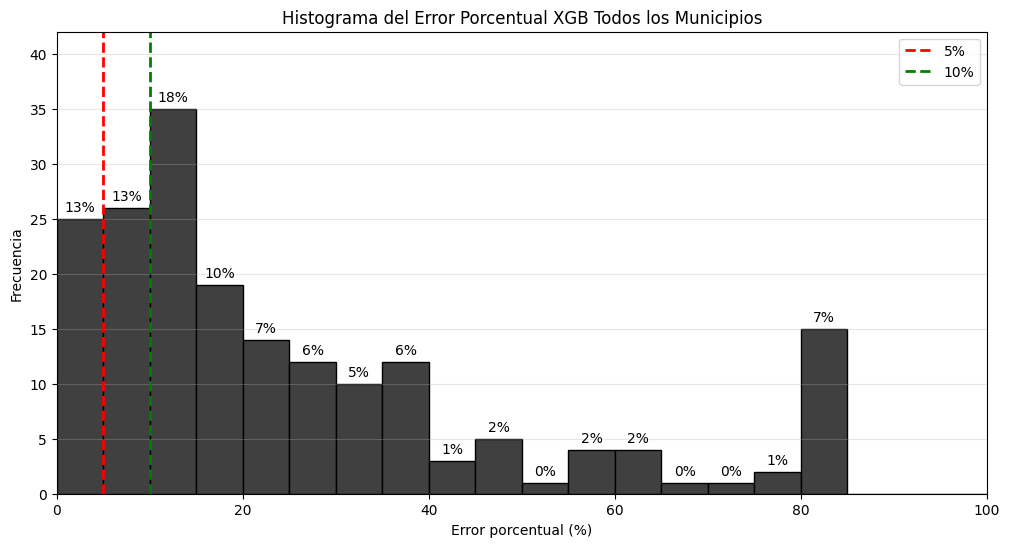

In [47]:
plt.figure(figsize=(12, 6))

# Rango de zoom

zoom_range = results_model_xgb["Error %"].clip(lower=0, upper=80)

# Bins de 5%

bins = np.arange(0, 105, 5)

# Histograma

counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue

total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_ch`

In [48]:
from scipy import sparse

extra_cols = ["url"]

# Convertir sparse o dense a DataFrame float
if sparse.issparse(X_test_prep_ch):
    X_test_ch_dense = X_test_prep_ch.toarray()
else:
    X_test_ch_dense = X_test_prep_ch

X_test_ch_df = pd.DataFrame(X_test_ch_dense, dtype=float).reset_index(drop=True)

# Resetear y_test
y_test_ch_reset = y_test_ch.reset_index(drop=True)

# Filas originales del test
test_rows_ch = data_ch.loc[test_indices_ch].reset_index(drop=True)

# Evaluación
results_model_xgb_ch = evaluation_table(
    lgbm_ch,
    X_test_ch_df,
    y_test_ch_reset,
    test_rows_ch,
    extra_cols
)

results_model_xgb_ch.head(20)


,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"550,000.00","269,933.21","280,066.79",50.92,https://www.casasymas.com.uy/propiedad/51665-c...
1,"498,000.00","744,701.72","246,701.72",49.54,https://www.casasymas.com.uy/propiedad/196254-...
2,"145,000.00","211,473.13","66,473.13",45.84,https://www.casasymas.com.uy/propiedad/119504-...
3,"595,000.00","338,243.24","256,756.76",43.15,https://www.casasymas.com.uy/propiedad/193907-...
4,"515,000.00","316,090.19","198,909.81",38.62,https://www.casasymas.com.uy/propiedad/191507-...
5,"360,000.00","489,382.27","129,382.27",35.94,https://www.casasymas.com.uy/propiedad/204053-...
6,"345,000.00","227,764.10","117,235.90",33.98,https://www.casasymas.com.uy/propiedad/184603-...
7,"390,000.00","263,114.39","126,885.61",32.53,https://www.casasymas.com.uy/propiedad/203597-...
8,"140,000.00","184,845.34","44,845.34",32.03,https://www.casasymas.com.uy/propiedad/90763-c...
9,"510,000.00","365,536.11","144,463.89",28.33,https://www.casasymas.com.uy/propiedad/192140-...


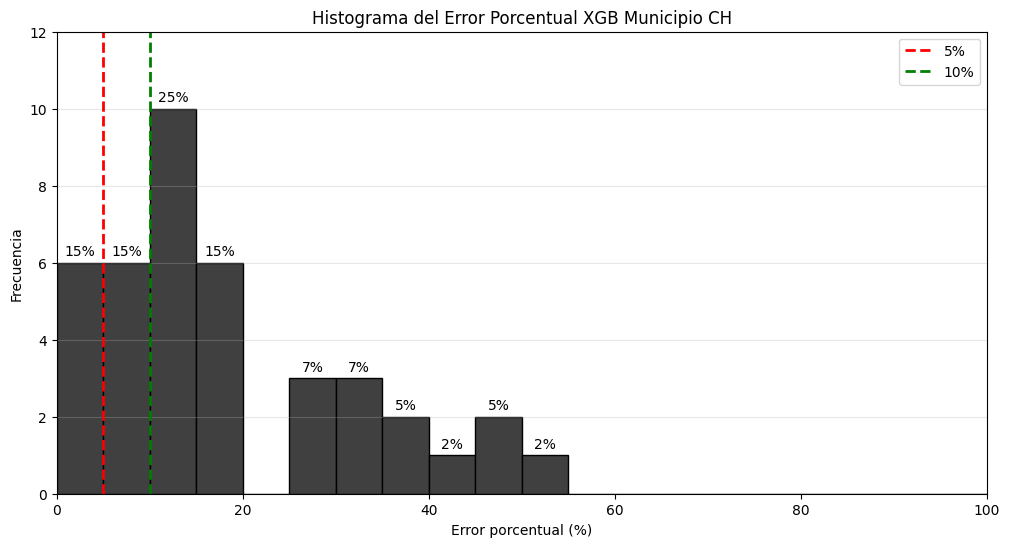

In [49]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_e`

In [50]:
results_model_xgb_e = evaluation_table(
    xgb_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_xgb_e.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"125,000.00","364,360.72","239,360.72",191.49,https://www.casasymas.com.uy/propiedad/119558-...
1,"99,000.00","250,259.59","151,259.59",152.79,https://www.casasymas.com.uy/propiedad/79956-c...
2,"145,000.00","249,257.77","104,257.77",71.90,https://www.casasymas.com.uy/propiedad/183832-...
3,"1,800,000.00","588,089.06","1,211,910.94",67.33,https://www.casasymas.com.uy/propiedad/63219-c...
4,"235,000.00","370,365.47","135,365.47",57.60,https://www.casasymas.com.uy/propiedad/202567-...
5,"460,000.00","245,959.45","214,040.55",46.53,https://www.casasymas.com.uy/propiedad/203811-...
6,"460,000.00","245,959.45","214,040.55",46.53,https://www.casasymas.com.uy/propiedad/119576-...
7,"650,000.00","950,989.00","300,989.00",46.31,https://www.casasymas.com.uy/propiedad/166354-...
8,"260,000.00","373,309.78","113,309.78",43.58,https://www.casasymas.com.uy/propiedad/189510-...
9,"275,000.00","176,138.73","98,861.27",35.95,https://www.casasymas.com.uy/propiedad/206801-...


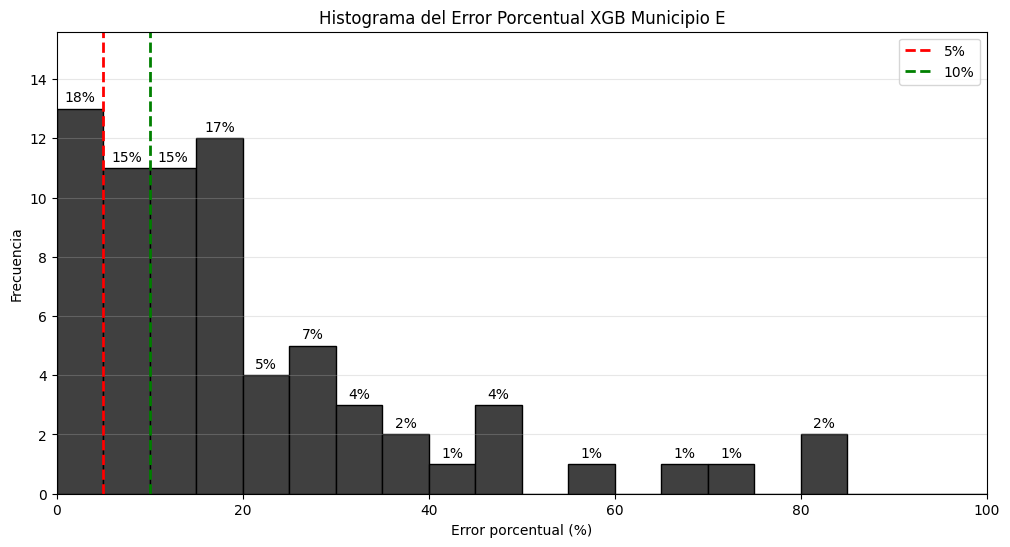

In [51]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lgbm`

In [52]:
results_model_lgbm = evaluation_table(
    model_lgbm,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_lgbm.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"75,000.00","290,429.38","215,429.38",287.24,https://www.casasymas.com.uy/propiedad/190700-...
1,"64,000.00","194,116.92","130,116.92",203.31,https://www.casasymas.com.uy/propiedad/127393-...
2,"79,000.00","204,958.84","125,958.84",159.44,https://www.casasymas.com.uy/propiedad/204682-...
3,"137,900.00","353,417.33","215,517.33",156.29,https://www.casasymas.com.uy/propiedad/205556-...
4,"59,000.00","149,255.87","90,255.87",152.98,https://www.casasymas.com.uy/propiedad/186243-...
5,"242,000.00","541,655.61","299,655.61",123.82,https://www.casasymas.com.uy/propiedad/155770-...
6,"176,000.00","391,276.63","215,276.63",122.32,https://www.casasymas.com.uy/propiedad/182694-...
7,"395,000.00","874,562.81","479,562.81",121.41,https://www.casasymas.com.uy/propiedad/151503-...
8,"155,000.00","333,476.70","178,476.70",115.15,https://www.casasymas.com.uy/propiedad/98689-c...
9,"85,000.00","170,691.43","85,691.43",100.81,https://www.casasymas.com.uy/propiedad/159205-...


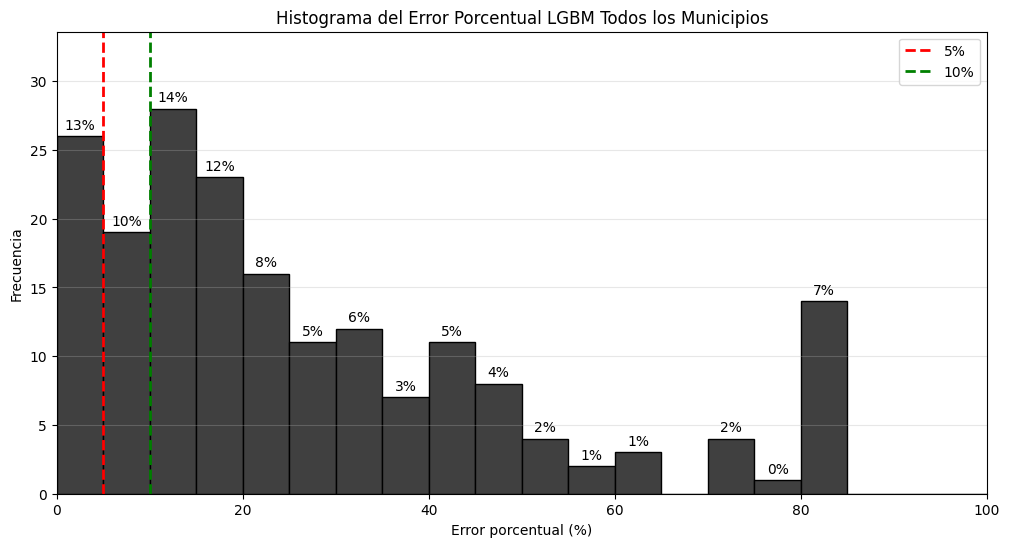

In [53]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_ch`

In [54]:
results_model_lgbm_ch = evaluation_table(
    lgbm_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_lgbm_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"550,000.00","269,933.21","280,066.79",50.92,https://www.casasymas.com.uy/propiedad/51665-c...
1,"498,000.00","744,701.72","246,701.72",49.54,https://www.casasymas.com.uy/propiedad/196254-...
2,"145,000.00","211,473.13","66,473.13",45.84,https://www.casasymas.com.uy/propiedad/119504-...
3,"595,000.00","338,243.24","256,756.76",43.15,https://www.casasymas.com.uy/propiedad/193907-...
4,"515,000.00","316,090.19","198,909.81",38.62,https://www.casasymas.com.uy/propiedad/191507-...
5,"360,000.00","489,382.27","129,382.27",35.94,https://www.casasymas.com.uy/propiedad/204053-...
6,"345,000.00","227,764.10","117,235.90",33.98,https://www.casasymas.com.uy/propiedad/184603-...
7,"390,000.00","263,114.39","126,885.61",32.53,https://www.casasymas.com.uy/propiedad/203597-...
8,"140,000.00","184,845.34","44,845.34",32.03,https://www.casasymas.com.uy/propiedad/90763-c...
9,"510,000.00","365,536.11","144,463.89",28.33,https://www.casasymas.com.uy/propiedad/192140-...


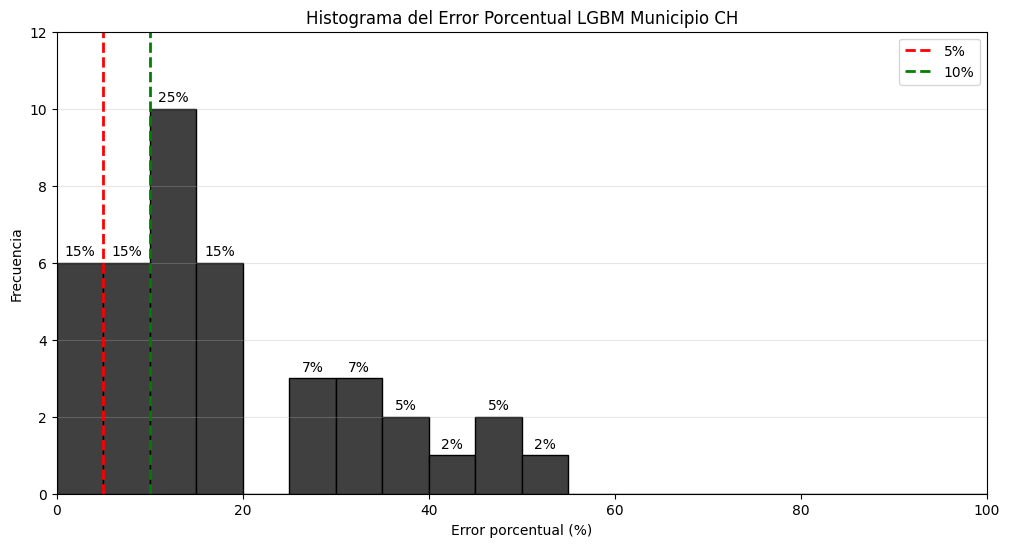

In [55]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_e`

In [56]:
results_model_lgbm_e = evaluation_table(
    lgbm_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_lgbm_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"125,000.00","913,717.32","788,717.32",630.97,https://www.casasymas.com.uy/propiedad/119558-...
1,"99,000.00","535,225.28","436,225.28",440.63,https://www.casasymas.com.uy/propiedad/79956-c...
2,"134,000.00","352,360.84","218,360.84",162.96,https://www.casasymas.com.uy/propiedad/130556-...
3,"350,000.00","776,783.82","426,783.82",121.94,https://www.casasymas.com.uy/propiedad/190292-...
4,"145,000.00","263,552.06","118,552.06",81.76,https://www.casasymas.com.uy/propiedad/183832-...
5,"1,800,000.00","646,991.69","1,153,008.31",64.06,https://www.casasymas.com.uy/propiedad/63219-c...
6,"1,690,000.00","725,170.16","964,829.84",57.09,https://www.casasymas.com.uy/propiedad/201502-...
7,"380,000.00","583,434.63","203,434.63",53.54,https://www.casasymas.com.uy/propiedad/204883-...
8,"203,400.00","310,932.59","107,532.59",52.87,https://www.casasymas.com.uy/propiedad/90237-c...
9,"230,000.00","337,754.26","107,754.26",46.85,https://www.casasymas.com.uy/propiedad/188240-...


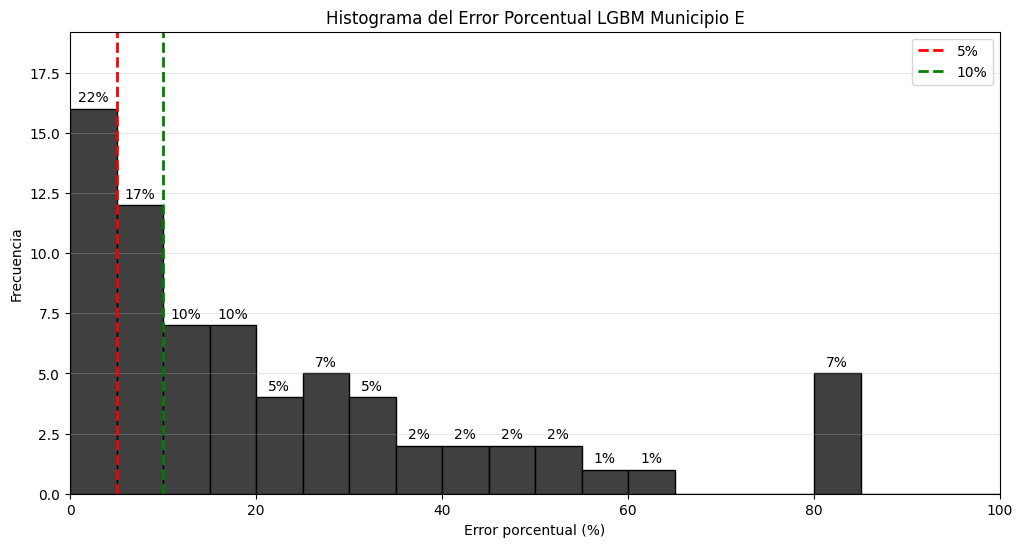

In [57]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr`

In [58]:
results_model_lr = evaluation_table(
    model_lr,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_lr.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"137,900.00","454,571.32","316,671.32",229.64,https://www.casasymas.com.uy/propiedad/205556-...
1,"64,000.00","149,805.35","85,805.35",134.07,https://www.casasymas.com.uy/propiedad/127393-...
2,"79,000.00","160,970.80","81,970.80",103.76,https://www.casasymas.com.uy/propiedad/204682-...
3,"55,000.00","108,980.28","53,980.28",98.15,https://www.casasymas.com.uy/propiedad/120273-...
4,"242,000.00","478,596.67","236,596.67",97.77,https://www.casasymas.com.uy/propiedad/155770-...
5,"176,000.00","341,692.90","165,692.90",94.14,https://www.casasymas.com.uy/propiedad/182694-...
6,"170,000.00","14,484.37","155,515.63",91.48,https://www.casasymas.com.uy/propiedad/207263-...
7,"850,000.00","1,598,599.08","748,599.08",88.07,https://www.casasymas.com.uy/propiedad/65438-c...
8,"155,000.00","19,370.03","135,629.97",87.50,https://www.casasymas.com.uy/propiedad/98689-c...
9,"345,000.00","624,190.63","279,190.63",80.92,https://www.casasymas.com.uy/propiedad/208151-...


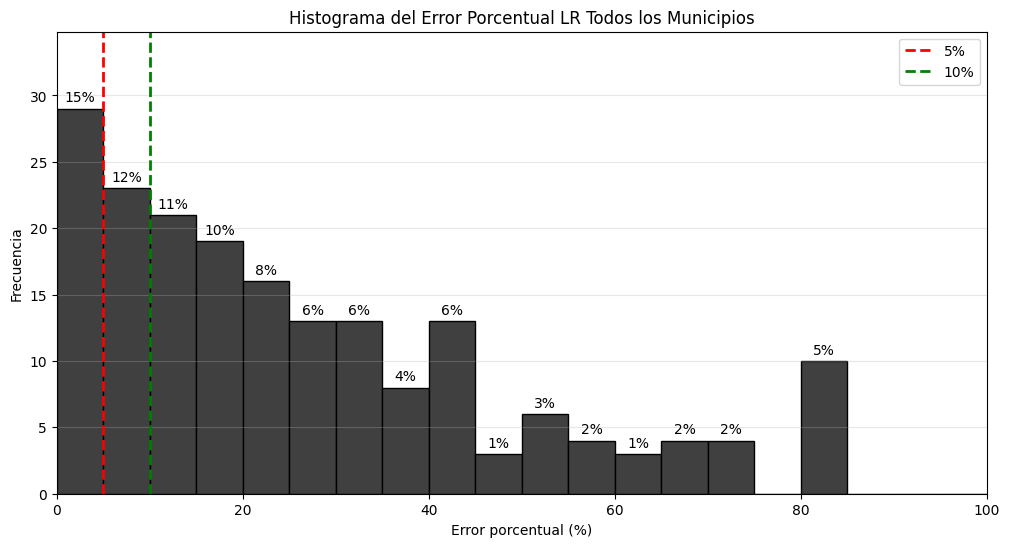

In [59]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_ch`

In [60]:
results_model_lr_ch = evaluation_table(
    model_lr_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_lr_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"420,000.00","700,572.07","280,572.07",66.80,https://www.casasymas.com.uy/propiedad/38319-c...
1,"140,000.00","203,492.66","63,492.66",45.35,https://www.casasymas.com.uy/propiedad/90763-c...
2,"780,000.00","454,850.06","325,149.94",41.69,https://www.casasymas.com.uy/propiedad/182580-...
3,"550,000.00","323,044.18","226,955.82",41.26,https://www.casasymas.com.uy/propiedad/51665-c...
4,"130,000.00","181,630.98","51,630.98",39.72,https://www.casasymas.com.uy/propiedad/168176-...
5,"510,000.00","310,703.21","199,296.79",39.08,https://www.casasymas.com.uy/propiedad/192140-...
6,"390,000.00","250,244.07","139,755.93",35.83,https://www.casasymas.com.uy/propiedad/203597-...
7,"345,000.00","223,519.11","121,480.89",35.21,https://www.casasymas.com.uy/propiedad/184603-...
8,"180,000.00","240,855.26","60,855.26",33.81,https://www.casasymas.com.uy/propiedad/51740-c...
9,"1,090,000.00","1,439,806.37","349,806.37",32.09,https://www.casasymas.com.uy/propiedad/111111-...


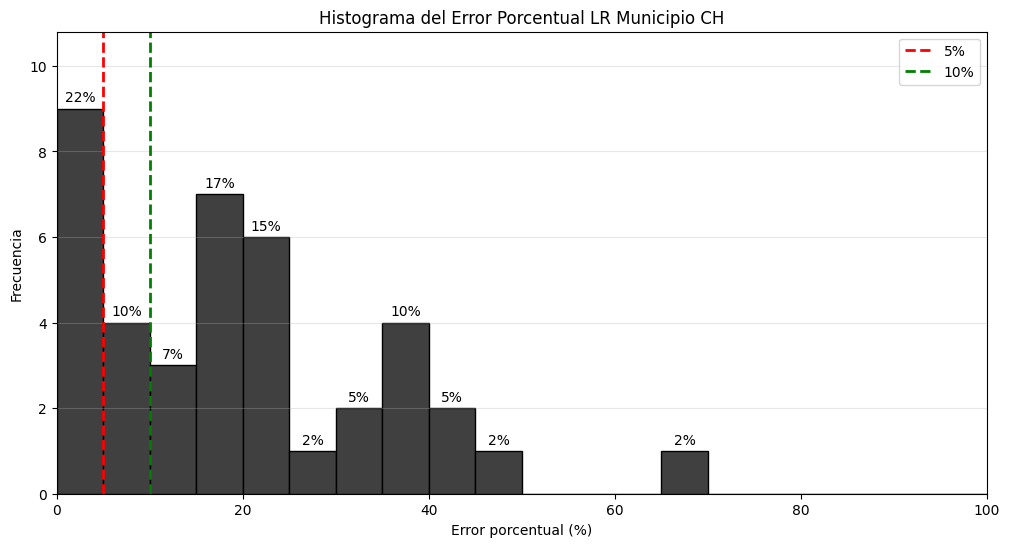

In [61]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_e`

In [63]:
results_model_lr_e = evaluation_table(
    model_lr_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_lr_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"125,000.00","513,929.20","388,929.20",311.14,https://www.casasymas.com.uy/propiedad/119558-...
1,"99,000.00","231,392.34","132,392.34",133.73,https://www.casasymas.com.uy/propiedad/79956-c...
2,"145,000.00","296,021.58","151,021.58",104.15,https://www.casasymas.com.uy/propiedad/183832-...
3,"203,400.00","388,611.87","185,211.87",91.06,https://www.casasymas.com.uy/propiedad/90237-c...
4,"235,000.00","395,369.80","160,369.80",68.24,https://www.casasymas.com.uy/propiedad/194124-...
5,"260,000.00","418,575.51","158,575.51",60.99,https://www.casasymas.com.uy/propiedad/189510-...
6,"1,800,000.00","704,508.78","1,095,491.22",60.86,https://www.casasymas.com.uy/propiedad/63219-c...
7,"770,000.00","1,109,615.19","339,615.19",44.11,https://www.casasymas.com.uy/propiedad/198415-...
8,"395,000.00","223,997.79","171,002.21",43.29,https://www.casasymas.com.uy/propiedad/157923-...
9,"410,000.00","583,571.05","173,571.05",42.33,https://www.casasymas.com.uy/propiedad/185077-...


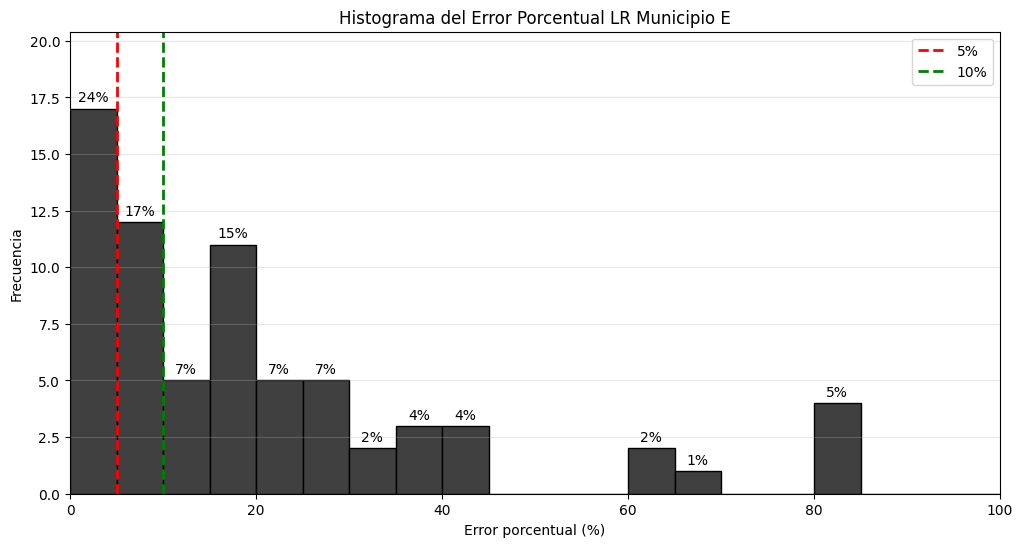

In [64]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_all_municipios`

In [65]:
results_model_rf_all_municipios = evaluation_table(
    rf_all_municipios,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    data.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_rf_all_municipios.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"75,000.00","244,621.78","169,621.78",226.16,https://www.casasymas.com.uy/propiedad/190700-...
1,"137,900.00","392,102.81","254,202.81",184.34,https://www.casasymas.com.uy/propiedad/205556-...
2,"64,000.00","171,736.53","107,736.53",168.34,https://www.casasymas.com.uy/propiedad/127393-...
3,"59,000.00","137,554.53","78,554.53",133.14,https://www.casasymas.com.uy/propiedad/186243-...
4,"79,000.00","183,604.60","104,604.60",132.41,https://www.casasymas.com.uy/propiedad/204682-...
5,"55,000.00","120,744.56","65,744.56",119.54,https://www.casasymas.com.uy/propiedad/120273-...
6,"59,500.00","127,888.60","68,388.60",114.94,https://www.casasymas.com.uy/propiedad/118244-...
7,"85,000.00","175,480.72","90,480.72",106.45,https://www.casasymas.com.uy/propiedad/159205-...
8,"176,000.00","363,222.94","187,222.94",106.38,https://www.casasymas.com.uy/propiedad/182694-...
9,"70,000.00","139,278.26","69,278.26",98.97,https://www.casasymas.com.uy/propiedad/210321-...


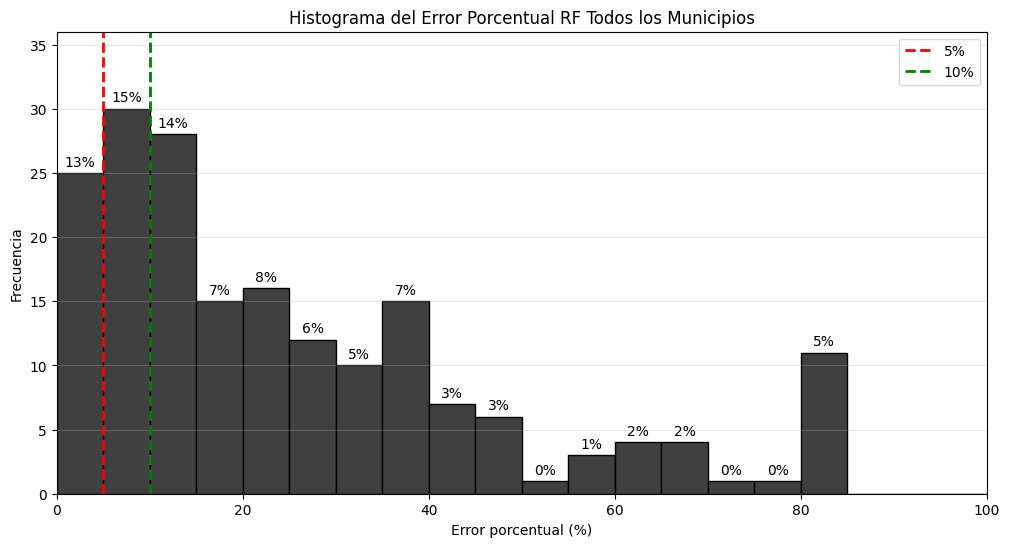

In [66]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_all_municipios["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipios_ch`

In [67]:
results_model_rf_municipio_ch = evaluation_table(
    rf_municipio_ch,
    X_test_prep_ch,
    y_test_ch.values,
    data.loc[test_indices_ch],
    extra_cols=["url"]
)

results_model_rf_municipio_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"360,000.00","553,502.46","193,502.46",53.75,https://www.casasymas.com.uy/propiedad/204053-...
1,"550,000.00","292,632.68","257,367.32",46.79,https://www.casasymas.com.uy/propiedad/51665-c...
2,"145,000.00","212,002.83","67,002.83",46.21,https://www.casasymas.com.uy/propiedad/119504-...
3,"148,000.00","200,480.06","52,480.06",35.46,https://www.casasymas.com.uy/propiedad/200103-...
4,"510,000.00","334,667.15","175,332.85",34.38,https://www.casasymas.com.uy/propiedad/192140-...
5,"390,000.00","271,614.95","118,385.05",30.36,https://www.casasymas.com.uy/propiedad/203597-...
6,"595,000.00","429,228.64","165,771.36",27.86,https://www.casasymas.com.uy/propiedad/193907-...
7,"130,000.00","163,604.65","33,604.65",25.85,https://www.casasymas.com.uy/propiedad/168176-...
8,"498,000.00","625,773.39","127,773.39",25.66,https://www.casasymas.com.uy/propiedad/196254-...
9,"515,000.00","391,588.94","123,411.06",23.96,https://www.casasymas.com.uy/propiedad/191507-...


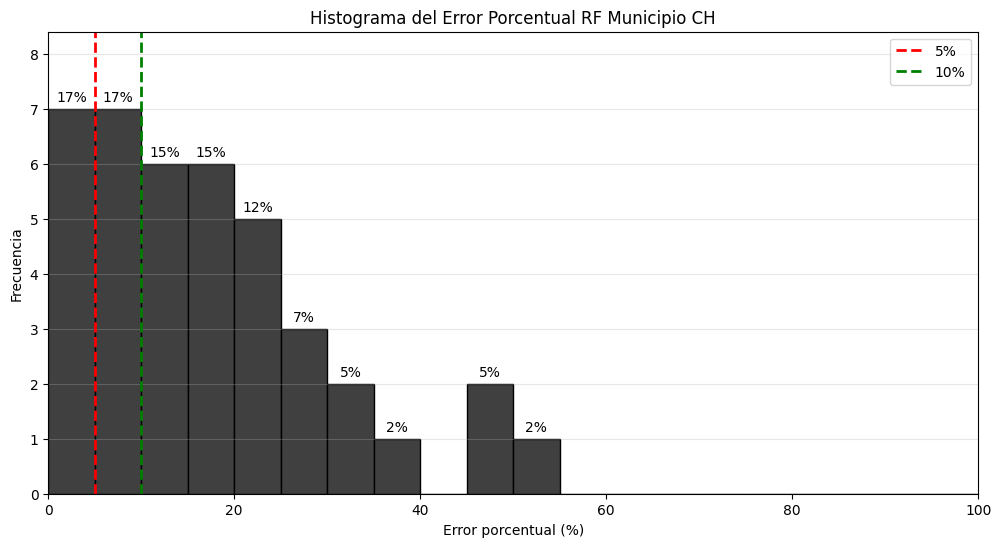

In [68]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipio_e`

In [69]:
results_model_rf_municipio_e = evaluation_table(
    rf_municipio_e,
    X_test_prep_e,
    y_test_e.values,
    data.loc[test_indices_e],
    extra_cols=["url"]
)

results_model_rf_municipio_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"125,000.00","579,747.99","454,747.99",363.80,https://www.casasymas.com.uy/propiedad/119558-...
1,"99,000.00","363,207.74","264,207.74",266.88,https://www.casasymas.com.uy/propiedad/79956-c...
2,"145,000.00","293,497.00","148,497.00",102.41,https://www.casasymas.com.uy/propiedad/183832-...
3,"1,800,000.00","675,573.61","1,124,426.39",62.47,https://www.casasymas.com.uy/propiedad/63219-c...
4,"203,400.00","326,123.93","122,723.93",60.34,https://www.casasymas.com.uy/propiedad/90237-c...
5,"134,000.00","211,538.93","77,538.93",57.86,https://www.casasymas.com.uy/propiedad/130556-...
6,"350,000.00","513,735.06","163,735.06",46.78,https://www.casasymas.com.uy/propiedad/190292-...
7,"260,000.00","377,187.52","117,187.52",45.07,https://www.casasymas.com.uy/propiedad/189510-...
8,"235,000.00","333,644.39","98,644.39",41.98,https://www.casasymas.com.uy/propiedad/202567-...
9,"380,000.00","536,797.01","156,797.01",41.26,https://www.casasymas.com.uy/propiedad/204883-...


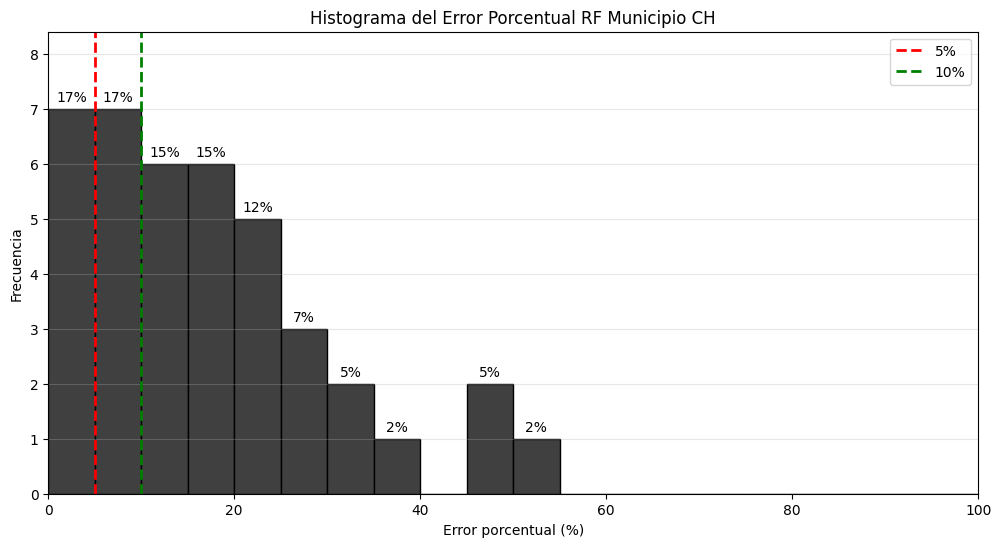

In [70]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()